# Machine Learning Algorithms - (2) Linear Regression

<div style="border: 1px solid #007acc; background-color: #e6f4ff; padding: 10px; border-radius: 5px; color: black;">
  <strong>📘 Info:</strong> I do not claim ownership of the content in this notebook. It is based on different tutorials and resources. Parts of the code or text may have been copy-pasted or adapted directly from those or other sources for learning purposes.
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [3]:
np.random.seed(42)

## 1. What is Linear Regression?

Linear regression is one of the simplest yet most powerful **regression** algorithms in machine learning.
It models the relationship between a dependent variable $y$ and one or more independent variables $X$ by fitting a linear equation to observed data.

### 1.1. Assumptions
- Linearity: The relationship between the independent variables $X$ and the dependent variable $y$ is linear.
  - $y = \theta_0 + \theta_1 x_1 + \dots + \theta_n x_n + \varepsilon$
  - Implication: The model captures the trend using a straight line (or hyperplane in multivariate cases). If the relationship is non-linear, predictions and inferences may be invalid.
  - How to check: Plot $x$ and $y$ — if a pattern emerges (e.g., curve), linearity may be violated.
- Homoscedasticity: The variance of the residuals (errors) is constant across all levels of the independent variables.
  - $\text{Var}(\varepsilon_i) = \sigma^2 \quad \forall i$
  - Implication: If residuals spread more widely at some levels of $x$, standard errors and hypothesis tests become unreliable.
  - Violation leads to: Heteroscedasticity — inflated type I errors and inefficient estimates.
  - How to check: Plot residuals vs. predictions — the spread should be roughly equal (no cone shape).
- Independence: All observations are independent of one another.
  - $\text{Cov}(y_i, y_j) = 0 \quad \text{for } i \neq j$
  - Implication: Dependencies (e.g., time-series autocorrelation or grouped data) can bias standard errors and lead to invalid inference.
  - How to check: For time-series, plot residuals over time or use tests like Durbin-Watson.
- Normality: The residuals are normally distributed.
  - $\varepsilon_i = y_i - \hat{y}_i \sim \mathcal{N}(0, \sigma^2)$
  - Implication: This assumption is mainly important when you're performing statistical inference.
  - How to check: Use a histogram or Q-Q plot of residuals. A roughly bell-shaped or straight Q-Q line suggests normality.


### 1.2. Univariate Linear Regression

The model has one feature (independent variable):

$\hat{y} = \theta_0 + \theta_1 x$

Where:
- $\hat{y}$ is the predicted output
- $\theta_0$ is the intercept (bias term)
- $\theta_1$ is the weight (slope) for feature $x$

### 1.3. Multivariate Linear Regression

The model has multiple features:

$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n$

Or more compactly, using vector notation:

$\hat{y} = \theta_0 + \mathbf{x}^\top \boldsymbol{\theta}$

Where:
- $\mathbf{x}$ is the feature vector $[x_1, x_2, \dots, x_n]$
- $\boldsymbol{\theta}$ is the parameter vector $[\theta_1, \theta_2, \dots, \theta_n]$
- $\theta_0$ is often included by augmenting $\mathbf{x}$ with a 1 as its first element


## 2. The Loss Function: Residual Sum of Squares (RSS)

To fit a line to the data, we need a way to measure how "wrong" our model is — that is, how far the predicted values $\hat{y}_i$ are from the true values $y_i$.

The most common loss function for linear regression is the Residual Sum of Squares (RSS):

$\text{RSS} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

Where:
- $y_i$ is the actual value
- $\hat{y}_i$ is the predicted value from the model

Since we want to average this over all examples and avoid large gradients, we typically minimize the Mean Squared Error (MSE) instead:

$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

MSE measures the variance of the residuals, whereas Mean Absolute Error (MAE) measures the average of the residuals. Hence, MSE penalizes larger errors more than MAE, making it more sensitive to outliers.

Why Use Squared Errors?

- Squaring emphasizes larger errors (penalizes outliers more heavily).
- It's differentiable — which is required for optimization via gradient descent.
- It's convex in the case of linear regression — meaning there's a single global minimum.


When we say we are “fitting a line,” we mean we are finding the parameters $\theta_0, \theta_1$ (or more generally $\boldsymbol{\theta}$ that minimize the total squared difference between the true values and the predicted values.

This gives us a line that is as close as possible to all data points, in terms of squared distance.

## 3. Generating a Simple Dataset

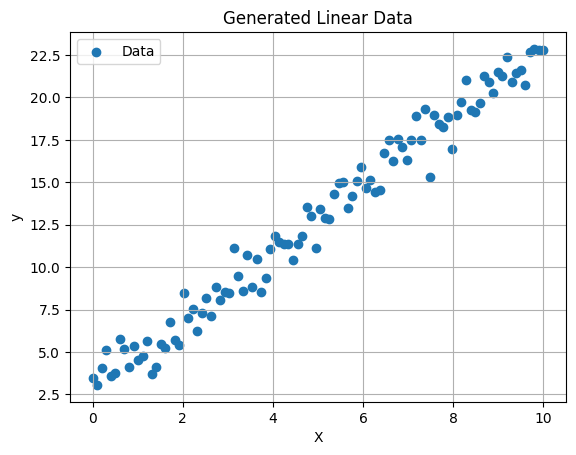

In [4]:
# Let's start with a simple linear function with some noise
def generate_linear_data(n_samples=100):
    X = np.linspace(0, 10, n_samples)
    noise = np.random.normal(0, 1, size=n_samples)
    y = 3 + 2 * X + noise  # θ₀ = 3, θ₁ = 2
    return X.reshape(-1, 1), y

X, y = generate_linear_data()

plt.scatter(X, y, label="Data")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Generated Linear Data")
plt.legend()
plt.grid(True)
plt.show()

## 4. Implementing Linear Regression

To train a linear regression model, we aim to find the best parameters ($\theta$) that minimize the Mean Squared Error (MSE) between the predicted and true values.

Gradient Descent is an iterative optimization algorithm used to minimize a function by updating parameters in the opposite direction of the gradient of the loss function.

For linear regression, the MSE loss function is:

$J(\theta, b) = \frac{1}{n} \sum_{i=1}^{n} \left( \hat{y}_i - y_i \right)^2 = \frac{1}{n} \sum_{i=1}^{n} \left( (\theta^\top x_i + b) - y_i \right)^2$

We update parameters using the following rules:

- $\theta := \theta - \alpha \cdot \frac{\partial J}{\partial \theta}$
- $b := b - \alpha \cdot \frac{\partial J}{\partial b}$

Where:
- $\alpha$ is the learning rate
- $\frac{\partial J}{\partial \theta}$ is the gradient of the loss with respect to the weights
- $\frac{\partial J}{\partial b}$ is the gradient with respect to the bias


Algorithm:

1. Initialize weights (`theta`) and bias (`b`) to zero.
2. Loop for `n_iters`:
   - Compute predictions: $\hat{y} = X \cdot \theta + b$
   - Calculate error: $\text{error} = \hat{y} - y$
   - Compute gradients:
     - $\frac{\partial J}{\partial \theta} = \frac{1}{n} X^T \cdot \text{error}$
     - $\frac{\partial J}{\partial b} = \frac{1}{n} \sum \text{error}$
   - Update weights and bias using the learning rate.
3. After convergence, use the model to make predictions with the learned parameters.

This method is flexible and can be extended to multivariate regression or regularized versions like Ridge and Lasso.

In [8]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_epochs=1000):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.theta = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.theta = np.zeros(n_features)
        self.bias = 0

        for _ in tqdm(range(self.n_epochs), desc="Training"):
            y_predicted = np.dot(X, self.theta) + self.bias
            error = y_predicted - y

            d_theta = (1 / n_samples) * np.dot(X.T, error)
            d_bias = (1 / n_samples) * np.sum(error)

            self.theta -= self.learning_rate * d_theta
            self.bias -= self.learning_rate * d_bias

    def predict(self, X):
        return np.dot(X, self.theta) + self.bias

Training: 100%|██████████| 1000/1000 [00:00<00:00, 86079.38it/s]

Theta (slope): 2.04
Bias (intercept): 2.62


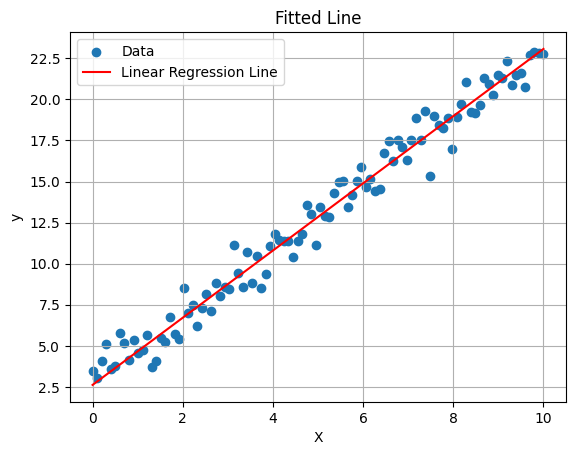

In [6]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

print(f"Theta (slope): {model.theta[0]:.2f}")
print(f"Bias (intercept): {model.bias:.2f}")

plt.scatter(X, y, label="Data")
plt.plot(X, y_pred, color='red', label="Linear Regression Line")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Fitted Line")
plt.grid(True)
plt.show()

## 5. Model Evaluation

In [7]:
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Squared Error (MSE): 0.83
Root Mean Squared Error (RMSE): 0.91


## 6. Summary and Takeaways

- Linear regression models a linear relationship between X and y
- Gradient Descent minimizes MSE by updating parameters iteratively
- Bias-variance tradeoff explains model generalization behavior